# Preview the Stickleback scans

The initial state of this notebook is a simple copy of [the notebook generated for the EAWAG Cichlids project](https://github.com/habi/EAWAG/blob/main/DisplayFishes.ipynb).

The cells below are used to set up the whole notebook.
They load needed libraries and set some default values.

In [1]:
# Load the modules we need
import platform
import os
import glob
import pandas
import imageio
import numpy
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn
import dask
import dask_image.imread
from dask.distributed import Client, LocalCluster
import skimage
from tqdm.auto import tqdm, trange

In [2]:
# Load our own log file parsing code
# This is loaded as a submodule to alleviate excessive copy-pasting between *all* projects we do
# See https://github.com/habi/BrukerSkyScanLogfileRuminator for details on its inner workings
from BrukerSkyScanLogfileRuminator.parsing_functions import *

In [3]:
# Set dask temporary folder
# Do this before creating a client: https://stackoverflow.com/a/62804525/323100
# We use the fast internal SSD for speed reasons
import tempfile
if 'Linux' in platform.system():
    # Check if me mounted the FastSSD, otherwise go to standard tmp file
    if os.path.exists(os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')):
        tmp = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD', 'tmp')
    else:
        tmp = tempfile.gettempdir()
elif 'Darwin' in platform.system():
    tmp = tempfile.gettempdir()
else:
    if 'anaklin' in platform.node():
        tmp = os.path.join('F:\\tmp')
    else:
        tmp = os.path.join('D:\\tmp')
dask.config.set({'temporary_directory': tmp})
print('Dask temporary files go to %s' % dask.config.get('temporary_directory'))

Dask temporary files go to /media/habi/Fast_SSD/tmp


In [4]:
from dask.distributed import Client
client = Client()

/home/habi/anaconda3/envs/sticklebacks/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37891 instead
  warnings.warn(


In [5]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:37891/status,
Dashboard: http://127.0.0.1:37891/status,Workers: 8
Total threads: 32,Total memory: 125.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35071,Workers: 8
Dashboard: http://127.0.0.1:37891/status,Total threads: 32
Started: Just now,Total memory: 125.79 GiB
Comm: tcp://127.0.0.1:41179,Total threads: 4
Dashboard: http://127.0.0.1:42093/status,Memory: 15.72 GiB
Nanny: tcp://127.0.0.1:38505,


In [6]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit
plt.rcParams['figure.dpi'] = 200

In [7]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [8]:
# Display all plots identically
lines = 3
# And then do something like
# plt.subplot(lines, int(numpy.ceil(len(Data) / float(lines))), c + 1)

Since the (tomographic) data can reside on different drives we set a folder to use below

In [9]:
# Different locations if running either on Linux or Windows
FastSSD = True
if 'Linux' in platform.system():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    else:
        BasePath = os.path.join(os.path.sep, 'home', 'habi', '2214')
elif 'Windows' in platform.system():
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        BasePath = os.path.join('N:\\')
Root = os.path.join(BasePath, 'IEE Stickleback')
print('We are loading all the data from %s' % Root)

We are loading all the data from /media/habi/Fast_SSD/IEE Stickleback


Now that we are set up, actually start to load/ingest the data.

In [10]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [11]:
# Get *all* log files
# Using os.walk is way faster than using recursive glob.glob, see DataWrangling.ipynb for details
# Not sorting the found logfiles is also making it quicker
Data['LogFile'] = [os.path.join(root, name)
                   for root, dirs, files in os.walk(Root)
                   for name in files
                   if name.endswith((".log"))]

In [12]:
# Get all folders
Data['Folder'] = [os.path.dirname(f) for f in Data['LogFile']]

In [13]:
# Show a (small) sampler of the loaded data as a first check
Data.sample(n=5)

,LogFile,Folder
29,/media/habi/Fast_SSD/IEE Stickleback/BucketOfF...,/media/habi/Fast_SSD/IEE Stickleback/BucketOfF...
42,/media/habi/Fast_SSD/IEE Stickleback/PilotScan...,/media/habi/Fast_SSD/IEE Stickleback/PilotScan...
50,/media/habi/Fast_SSD/IEE Stickleback/PilotScan...,/media/habi/Fast_SSD/IEE Stickleback/PilotScan...
16,/media/habi/Fast_SSD/IEE Stickleback/BucketOfF...,/media/habi/Fast_SSD/IEE Stickleback/BucketOfF...
7,/media/habi/Fast_SSD/IEE Stickleback/BucketOfF...,/media/habi/Fast_SSD/IEE Stickleback/BucketOfF...


In [14]:
# Check for samples which are not yet reconstructed
for c, row in Data.iterrows():
    # Iterate over every 'proj' folder
    if 'proj' in row.Folder:
        if 'TScopy' not in row.Folder and 'PR' not in row.Folder:
            # If there's nothing with 'rec*' on the same level, then tell us
            if not glob.glob(row.Folder.replace('proj', '*rec*')):
                print('- %s is missing matching reconstructions' % row.LogFile[len(Root) + 1:])

- PilotScans/F13_F3-07_14-15/heads_10um_proj/F13_F03-07_14-15.log is missing matching reconstructions
- PilotScans/F13_F3-07_14-15/whole_15um_proj/F13_F03-07_14-15.log is missing matching reconstructions
- PilotScans/F13_F3-07_14-15/whole_15um_proj/F13_F03-07_14-15~00.log is missing matching reconstructions
- PilotScans/F13_F3-07_14-15/whole_15um_proj/F13_F03-07_14-15~01.log is missing matching reconstructions
- PilotScans/F13_F3-07_14-15/whole_15um_proj/F13_F03-07_14-15~02.log is missing matching reconstructions
- PilotScans/F13_F3-07_14-15/whole_15um_proj/F13_F03-07_14-15~03.log is missing matching reconstructions


In [15]:
# Search for any .csv files in each folder.
# These are only generated when the "X/Y Alignment With a Reference Scan" was performed in NRecon.
# If those files do *not* exist we have missed to do it and should correct for this.
Data['XYAlignment'] = [glob.glob(os.path.join(f, '*T*.csv')) for f in Data['Folder']]

In [16]:
# Display samples which are missing the .csv-files for the XY-alignment
for c, row in Data.iterrows():
    # Iterate over every 'proj' folder
    if 'proj' in row['Folder']:
        if not row['XYAlignment']:
            if not any(x in row.LogFile for x in ['rectmp.log',  # because we only exclude temporary logfiles in a later step
                                                  'proj_nofilter',  # since these two scans of single teeth don't contain a reference scan
                                                  'TScopy',  # discard *t*hermal *s*hift data
                                                  os.path.join('TJ3', 'jaw_v1'),  # no reference scan
                                                  os.path.join('28', 'full_188um'),  # no reference scan
                                                  os.path.join('75', 'proj_stuck'),  # 103375\proj_stuck which got stuck
                                                  os.path.join('106985', 'proj'),  # 106985/proj is a b0rked scan where something went wrong with the exposure time
                                                  os.path.join('161543', 'head_30'),  # 161543\head_30um has no reference scan
                                                  os.path.join('21322', 'jaw'),  # two scans of 21322 which have no reference scan
                                                  os.path.join('21322', 'whole'),  # two scans of 21322 which have no reference scan
                                                  os.path.join('31', 'moved_proj'),  # MA31\moved_proj which moved during acquisition
                                                  os.path.join('95', 'proj', '14295'),  # no reference scan
                                                  os.path.join('104061', 'head', 'proj_pressure')]):   # We lost air pressure (in the building) during this scan
                print('- %s has *not* been X/Y aligned' % row.LogFile[len(Root) + 1:])

In [17]:
# Get rid of all the logfiles from all the folders that might be on disk but that we don't want to load the data from
for c, row in Data.iterrows():
    if 'rec' not in row.Folder:
        Data.drop([c], inplace=True)
    elif '_regions' in row.Folder:  # Exclude all log files that we write in this notebook (to $scan$_region folders)
        Data.drop([c], inplace=True)        
    elif 'SubScan' in row.Folder:
        Data.drop([c], inplace=True)
    elif 'rectmp.log' in row.LogFile:
        Data.drop([c], inplace=True)
# Reset dataframe to something that we would get if we only would have loaded the 'rec' files
Data = Data.reset_index(drop=True)

In [18]:
# Generate us some meaningful colums in the dataframe
Data['Sample'] = [os.path.basename(l).replace('_rec.log','') for l in Data['LogFile']]
Data['Scan'] = [os.path.basename(os.path.dirname(l)) for l in Data['LogFile']]

In [19]:
# Quickly show the data from the last loaded scans
Data

,LogFile,Folder,XYAlignment,Sample,Scan
0,/media/habi/Fast_SSD/IEE Stickleback/BucketOfF...,/media/habi/Fast_SSD/IEE Stickleback/BucketOfF...,[],Sticklebucket,17.5um_rec
1,/media/habi/Fast_SSD/IEE Stickleback/BucketOfF...,/media/habi/Fast_SSD/IEE Stickleback/BucketOfF...,[],Sticklebucket_B,rec
2,/media/habi/Fast_SSD/IEE Stickleback/BucketOfF...,/media/habi/Fast_SSD/IEE Stickleback/BucketOfF...,[],Sticklebucket_C,rec
3,/media/habi/Fast_SSD/IEE Stickleback/BucketOfF...,/media/habi/Fast_SSD/IEE Stickleback/BucketOfF...,[],Sticklebucket_D,rec
4,/media/habi/Fast_SSD/IEE Stickleback/PilotScan...,/media/habi/Fast_SSD/IEE Stickleback/PilotScan...,[],F13_F3-07_14-15,heads_15um_rec
5,/media/habi/Fast_SSD/IEE Stickleback/PilotScan...,/media/habi/Fast_SSD/IEE Stickleback/PilotScan...,[],F13_F3-07_14-15,heads_full_15um_rec
6,/media/habi/Fast_SSD/IEE Stickleback/PilotScan...,/media/habi/Fast_SSD/IEE Stickleback/PilotScan...,[],F13_F3-07_14-15,full_12um_rec


In [20]:
# Load the file names of all the reconstructions of all the scans
Data['Filenames Reconstructions'] = [sorted(glob.glob(os.path.join(f, '*rec0*.png'))) for f in Data['Folder']]
# How many reconstructions do we have?
Data['Number of reconstructions'] = [len(r) for r in Data['Filenames Reconstructions']]

In [21]:
# Drop samples which have either not been reconstructed yet or of which we deleted the reconstructions with
# `find . -name "*rec*.png" -type f -mtime +333 -delete`
# Based on https://stackoverflow.com/a/13851602
# for c,row in Data.iterrows():
#     if not row['Number of reconstructions']:
#         print('%s contains no PNG files, we might be currently reconstructing it' % row.Folder)
Data = Data[Data['Number of reconstructions'] > 0]
# Reset the dataframe count/index for easier indexing afterwards
Data.reset_index(drop=True, inplace=True)
print('We have %s folders with reconstructions' % (len(Data)))

We have 7 folders with reconstructions


In [22]:
# Get parameters to doublecheck from logfiles
Data['Voxelsize'] = [pixelsize(log) for log in Data['LogFile']]
Data['Filter'] = [whichfilter(log) for log in Data['LogFile']]
Data['Exposuretime'] = [exposuretime(log) for log in Data['LogFile']]
Data['Scanner'] = [scanner(log) for log in Data['LogFile']]
Data['Averaging'] = [averaging(log) for log in Data['LogFile']]
Data['ProjectionSize'] = [projection_size(log) for log in Data['LogFile']]
Data['RotationStep'] = [rotationstep(log) for log in Data['LogFile']]
Data['Grayvalue'] = [reconstruction_grayvalue(log) for log in Data['LogFile']]
Data['RingartefactCorrection'] = [ringremoval(log) for log in Data['LogFile']]
Data['BeamHardeningCorrection'] = [beamhardening(log) for log in Data['LogFile']]
Data['DefectPixelMasking'] = [defectpixelmasking(log) for log in Data['LogFile']]
Data['Scan date'] = [scandate(log) for log in Data['LogFile']]

In [23]:
for log in Data['LogFile']:
    print(log)
    scanner(log)

/media/habi/Fast_SSD/IEE Stickleback/BucketOfFish_A/17.5um_rec/Sticklebucket_rec.log
/media/habi/Fast_SSD/IEE Stickleback/BucketOfFish_B/rec/Sticklebucket_B_rec.log
/media/habi/Fast_SSD/IEE Stickleback/BucketOfFish_C/rec/Sticklebucket_C_rec.log
/media/habi/Fast_SSD/IEE Stickleback/BucketOfFish_D/rec/Sticklebucket_D_rec.log
/media/habi/Fast_SSD/IEE Stickleback/PilotScans/F13_F3-07_14-15_stained_20230811/heads_15um_rec/F13_F3-07_14-15_rec.log
/media/habi/Fast_SSD/IEE Stickleback/PilotScans/F13_F3-07_14-15_stained_20230811/heads_full_15um_rec/F13_F3-07_14-15_rec.log
/media/habi/Fast_SSD/IEE Stickleback/PilotScans/F13_F3-07_14-15_stained_20230815/full_12um_rec/F13_F3-07_14-15_rec.log


Display the parameters we extracted from the log files (with [our log file parser](https://github.com/habi/BrukerSkyScanLogfileRuminator)) to check for consistency.

In [24]:
# Check ring removal parameters
for machine in Data['Scanner'].unique():
    print('For the %s we have '
          'ringartefact-correction values of %s' % (machine,
                                                    Data[Data.Scanner == machine]['RingartefactCorrection'].unique()))

For the SkyScan 2214 we have ringartefact-correction values of [None]


In [25]:
# Display ring removal parameter
for rac in sorted(Data['RingartefactCorrection'].unique()):
    print('Ringartefact-correction %02s is found in %03s scans' % (rac,
                                                                   Data[Data.RingartefactCorrection == rac]['RingartefactCorrection'].count()))

Ringartefact-correction None is found in   0 scans


In [26]:
# Display ring removal parameter for non-zero values
for scanner in Data.Scanner.unique():
    print('----', scanner, '----')
    for c, row in Data[Data.Scanner == scanner].iterrows():
        if not row.RingartefactCorrection:  # is set to 'nan' when zero, so we only show the values that are set
            print('Fish %s scan %s was reconstructed with RAC of %s' % (row['Sample'],
                                                                        row['Scan'],
                                                                        row['RingartefactCorrection']))

---- SkyScan 2214 ----
Fish Sticklebucket scan 17.5um_rec was reconstructed with RAC of None
Fish Sticklebucket_B scan rec was reconstructed with RAC of None
Fish Sticklebucket_C scan rec was reconstructed with RAC of None
Fish Sticklebucket_D scan rec was reconstructed with RAC of None
Fish F13_F3-07_14-15 scan heads_15um_rec was reconstructed with RAC of None
Fish F13_F3-07_14-15 scan heads_full_15um_rec was reconstructed with RAC of None
Fish F13_F3-07_14-15 scan full_12um_rec was reconstructed with RAC of None


In [27]:
# Check beamhardening parameters
for scanner in Data.Scanner.unique():
    print('For the %s we have '
          'beamhardening correction values of %s' % (scanner,
                                                     Data[Data.Scanner == scanner]['BeamHardeningCorrection'].unique()))

For the SkyScan 2214 we have beamhardening correction values of [None]


In [28]:
# Display beamhardening parameters
for scanner in Data.Scanner.unique():
    print('----', scanner, '----')
    for c, row in Data[Data.Scanner == scanner].iterrows():
        if not row.BeamHardeningCorrection:  # is set to 'nan' when zero, so we only show the values that are set
            print('Scan %s of fish %s was reconstructed with beam hardening correction of %s' % (row['Sample'],
                                                                                                 row['Scan'],
                                                                                                 row['BeamHardeningCorrection']))

---- SkyScan 2214 ----
Scan Sticklebucket of fish 17.5um_rec was reconstructed with beam hardening correction of None
Scan Sticklebucket_B of fish rec was reconstructed with beam hardening correction of None
Scan Sticklebucket_C of fish rec was reconstructed with beam hardening correction of None
Scan Sticklebucket_D of fish rec was reconstructed with beam hardening correction of None
Scan F13_F3-07_14-15 of fish heads_15um_rec was reconstructed with beam hardening correction of None
Scan F13_F3-07_14-15 of fish heads_full_15um_rec was reconstructed with beam hardening correction of None
Scan F13_F3-07_14-15 of fish full_12um_rec was reconstructed with beam hardening correction of None


In [29]:
# Check defect pixel masking parameters
for scanner in Data.Scanner.unique():
    print('For the %s we have '
          'defect pixel masking values of %s' % (scanner,
                                                 Data[Data.Scanner == scanner]['DefectPixelMasking'].unique()))

For the SkyScan 2214 we have defect pixel masking values of [None]


In [30]:
# Display defect pixel masking parameters
for dpm in sorted(Data['DefectPixelMasking'].unique()):
    print('A defect pixel masking of %02s is found in %03s scans' % (dpm,
                                                                     Data[Data.DefectPixelMasking == dpm]['DefectPixelMasking'].count()))

A defect pixel masking of None is found in   0 scans


In [31]:
# seaborn.scatterplot(data=Data, x='Fish', y='DefectPixelMasking', hue='Scanner')
# plt.title('Defect pixel masking')
# plt.show()

In [32]:
# Display defect pixel masking parameters
for scanner in Data.Scanner.unique():
    print('----', scanner, '----')
    for c, row in Data[Data.Scanner == scanner].iterrows():
        if row.Scanner == 'SkyScan1272' and row.DefectPixelMasking != 50:
            print('Fish %s scan %s was reconstructed with DPM of %s' % (row['Fish'],
                                                                        row['Scan'],
                                                                        row['DefectPixelMasking']))
        if row.Scanner == 'SkyScan2214' and row.DefectPixelMasking != 0:
            print('Fish %s scan %s was reconstructed with DPM of %s' % (row['Fish'],
                                                                        row['Scan'],
                                                                        row['DefectPixelMasking']))

---- SkyScan 2214 ----


----
Now that we've double-checked some of the parameters (and corrected any issues that might have shown up) we start to load the preview images.
If the three cells below are uncommented, the machine-generated previews are shown, otherwise we just continue.

In [33]:
# Data['Filename PreviewImage'] = [sorted(glob.glob(os.path.join(f, '*_spr.bmp')))[0] for f in Data['Folder']]
# Data['PreviewImage'] = [dask_image.imread.imread(pip).squeeze()
#                         if pip
#                         else numpy.random.random((100, 100)) for pip in Data['Filename PreviewImage']]

In [34]:
# Make an approximately square overview image
# lines = 10

In [35]:
# for c, row in Data.iterrows():
#     plt.subplot(lines, int(numpy.ceil(len(Data) / float(lines))), c + 1)
#     plt.imshow(row.PreviewImage.squeeze())
#     plt.title(os.path.join(row['Sample'], row['Scan']))
#     plt.gca().add_artist(ScaleBar(row['Voxelsize'],
#                                   'um',
#                                   color='black',
#                                   frameon=True))
#     plt.axis('off')
# plt.tight_layout()
# plt.savefig(os.path.join(Root, 'ScanOverviews.png'),
#             bbox_inches='tight')
# plt.show()

Now we 'load' all reconstructions from disks into stacks.

In [36]:
# # Load all reconstructions DASK arrays
# Reconstructions = [dask_image.imread.imread(os.path.join(folder,'*rec*.png')) for folder in Data['Folder']]
# Load all reconstructions into ephemereal DASK arrays, with a nice progress bar...
Reconstructions = [None] * len(Data)
for c, row in tqdm(Data.iterrows(),
                   desc='Loading reconstructions',
                   total=len(Data)):
    Reconstructions[c] = dask_image.imread.imread(os.path.join(row['Folder'], '*rec*.png'))

Loading reconstructions:   0%|          | 0/7 [00:00<?, ?it/s]

In [37]:
# What do we have on disk?
print('We have %s reconstructions on %s' % (Data['Number of reconstructions'].sum(), Root))
print('This is about %s reconstructions per scan (%s scans in %s folders)' % (round(Data['Number of reconstructions'].sum() / len(Data)),
                                                                              len(Data),
                                                                              len(Data.Sample.unique())))

We have 27393 reconstructions on /media/habi/Fast_SSD/IEE Stickleback
This is about 3913 reconstructions per scan (7 scans in 5 folders)


In [38]:
# How big are the datasets?
Data['Size'] = [rec.shape for rec in Reconstructions]

In [39]:
# The three cardinal directions
# Names adapted to fishes: https://en.wikipedia.org/wiki/Fish_anatomy#Body
directions = ['Anteroposterior',
              'Lateral',
              'Dorsoventral']

In [40]:
# # Read or calculate the middle slices, put them into the dataframe and save them to disk
# for d, direction in enumerate(directions):
#     Data['Mid_' + direction] = ''
# for c, row in tqdm(Data.iterrows(), desc='Working on central images', total=len(Data)):
#     for d, direction in tqdm(enumerate(directions),
#                              desc='%s/%s' % (row['Sample'], row['Scan']),
#                              leave=False,
#                              total=len(directions)):
#         outfilepath = os.path.join(os.path.dirname(row['Folder']),
#                                    '%s.%s.Center.%s.png' % (row['Sample'], row['Scan'], direction))
#         if os.path.exists(outfilepath):
#             try:
#                 Data.at[c, 'Mid_' + direction] = dask_image.imread.imread(outfilepath)
#             except:
#                 print('Something went wrong with the %s image of %s/%s' % (direction, row['Sample'], row['Scan']))
#                 print('Try to delete "%s" and restart the notebook' % outfilepath)
#         else:
#             # Generate requested axial view
#             if 'Anteroposterior' in direction:
#                 Data.at[c, 'Mid_' + direction] = Reconstructions[c][row.Size[0] // 2].compute()
#             if 'Lateral' in direction:
#                 Data.at[c, 'Mid_' + direction] = Reconstructions[c][:, row.Size[1] // 2, :].compute()
#             if 'Dorsoventral' in direction:
#                 Data.at[c, 'Mid_' + direction] = Reconstructions[c][:, :, row.Size[2] // 2].compute()
#             # Save the calculated 'direction' view to disk
#             imageio.imwrite(outfilepath, (Data.at[c, 'Mid_' + direction]))

In [41]:
# # Show/save middle slices
# for c, row in tqdm(Data.iterrows(),
#                    desc='Saving overview of central images',
#                    total=len(Data)):
#     outfilepath = os.path.join(os.path.dirname(row['Folder']),
#                                '%s.%s.CentralSlices.png' % (row['Sample'], row['Scan']))
#     if not os.path.exists(outfilepath):
#         for d, direction in tqdm(enumerate(directions),
#                                  desc='%s/%s' % (row['Sample'], row['Scan']),
#                                  leave=False,
#                                  total=len(directions)):
#             plt.subplot(1, 3, d + 1)
#             plt.imshow(row['Mid_' + direction].squeeze())
#             if d == 0:
#                 plt.axhline(row.Size[1] // 2, c=seaborn.color_palette()[0])
#                 plt.axvline(row.Size[2] // 2, c=seaborn.color_palette()[1])
#                 plt.gca().add_artist(ScaleBar(row['Voxelsize'],
#                                               'um',
#                                               color=seaborn.color_palette()[2]))
#             elif d == 1:
#                 plt.axhline(row.Size[0] // 2, c=seaborn.color_palette()[2])
#                 plt.axvline(row.Size[2] // 2, c=seaborn.color_palette()[1])
#                 plt.gca().add_artist(ScaleBar(row['Voxelsize'],
#                                               'um',
#                                               color=seaborn.color_palette()[0]))
#             else:
#                 plt.axhline(row.Size[0] // 2, c=seaborn.color_palette()[2])
#                 plt.axvline(row.Size[1] // 2, c=seaborn.color_palette()[0])
#                 plt.gca().add_artist(ScaleBar(row['Voxelsize'],
#                                               'um',
#                                               color=seaborn.color_palette()[1]))
#             plt.title('%s\nCentral %s slice' % (os.path.join(row['Sample'], row['Scan']), direction.lower()))
#             plt.axis('off')
#         plt.savefig(outfilepath,
#                     transparent=True,
#                     bbox_inches='tight')
#         plt.show()

In [42]:
# Read or calculate the directional MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_' + direction] = ''
for c, row in tqdm(Data.iterrows(), desc='Working on MIPs', total=len(Data)):
    for d, direction in tqdm(enumerate(directions),
                             desc='%s/%s' % (row['Sample'], row['Scan']),
                             leave=False,
                             total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']),
                                   '%s.%s.MIP.%s.png' % (row['Sample'], row['Scan'], direction))
        if os.path.exists(outfilepath):
            try:
                Data.at[c, 'MIP_' + direction] = dask_image.imread.imread(outfilepath).squeeze()
            except:
                print('Something went wrong with the %s image of %s/%s %s' % (direction, row['Sample'], row['Scan']))
                print('Try to delete %s and restart the notebook' % outfilepath[len(Root):])
        else:
            # Generate MIP
            # drop last axis, since dask.imread insists on reading reconstructions PNGs as RGB
            mip = Reconstructions[c][:,:,:,0].max(axis=d).compute()
            Data.at[c, 'MIP_' + direction] = mip
            # Save it out
            imageio.imwrite(outfilepath, mip.astype('uint8'))

Working on MIPs:   0%|          | 0/7 [00:00<?, ?it/s]

Sticklebucket/17.5um_rec:   0%|          | 0/3 [00:00<?, ?it/s]

Sticklebucket_B/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Sticklebucket_C/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Sticklebucket_D/rec:   0%|          | 0/3 [00:00<?, ?it/s]

F13_F3-07_14-15/heads_15um_rec:   0%|          | 0/3 [00:00<?, ?it/s]

F13_F3-07_14-15/heads_full_15um_rec:   0%|          | 0/3 [00:00<?, ?it/s]

F13_F3-07_14-15/full_12um_rec:   0%|          | 0/3 [00:00<?, ?it/s]

Saving overview of MIP images:   0%|          | 0/7 [00:00<?, ?it/s]

Sticklebucket_D/rec:   0%|          | 0/3 [00:00<?, ?it/s]

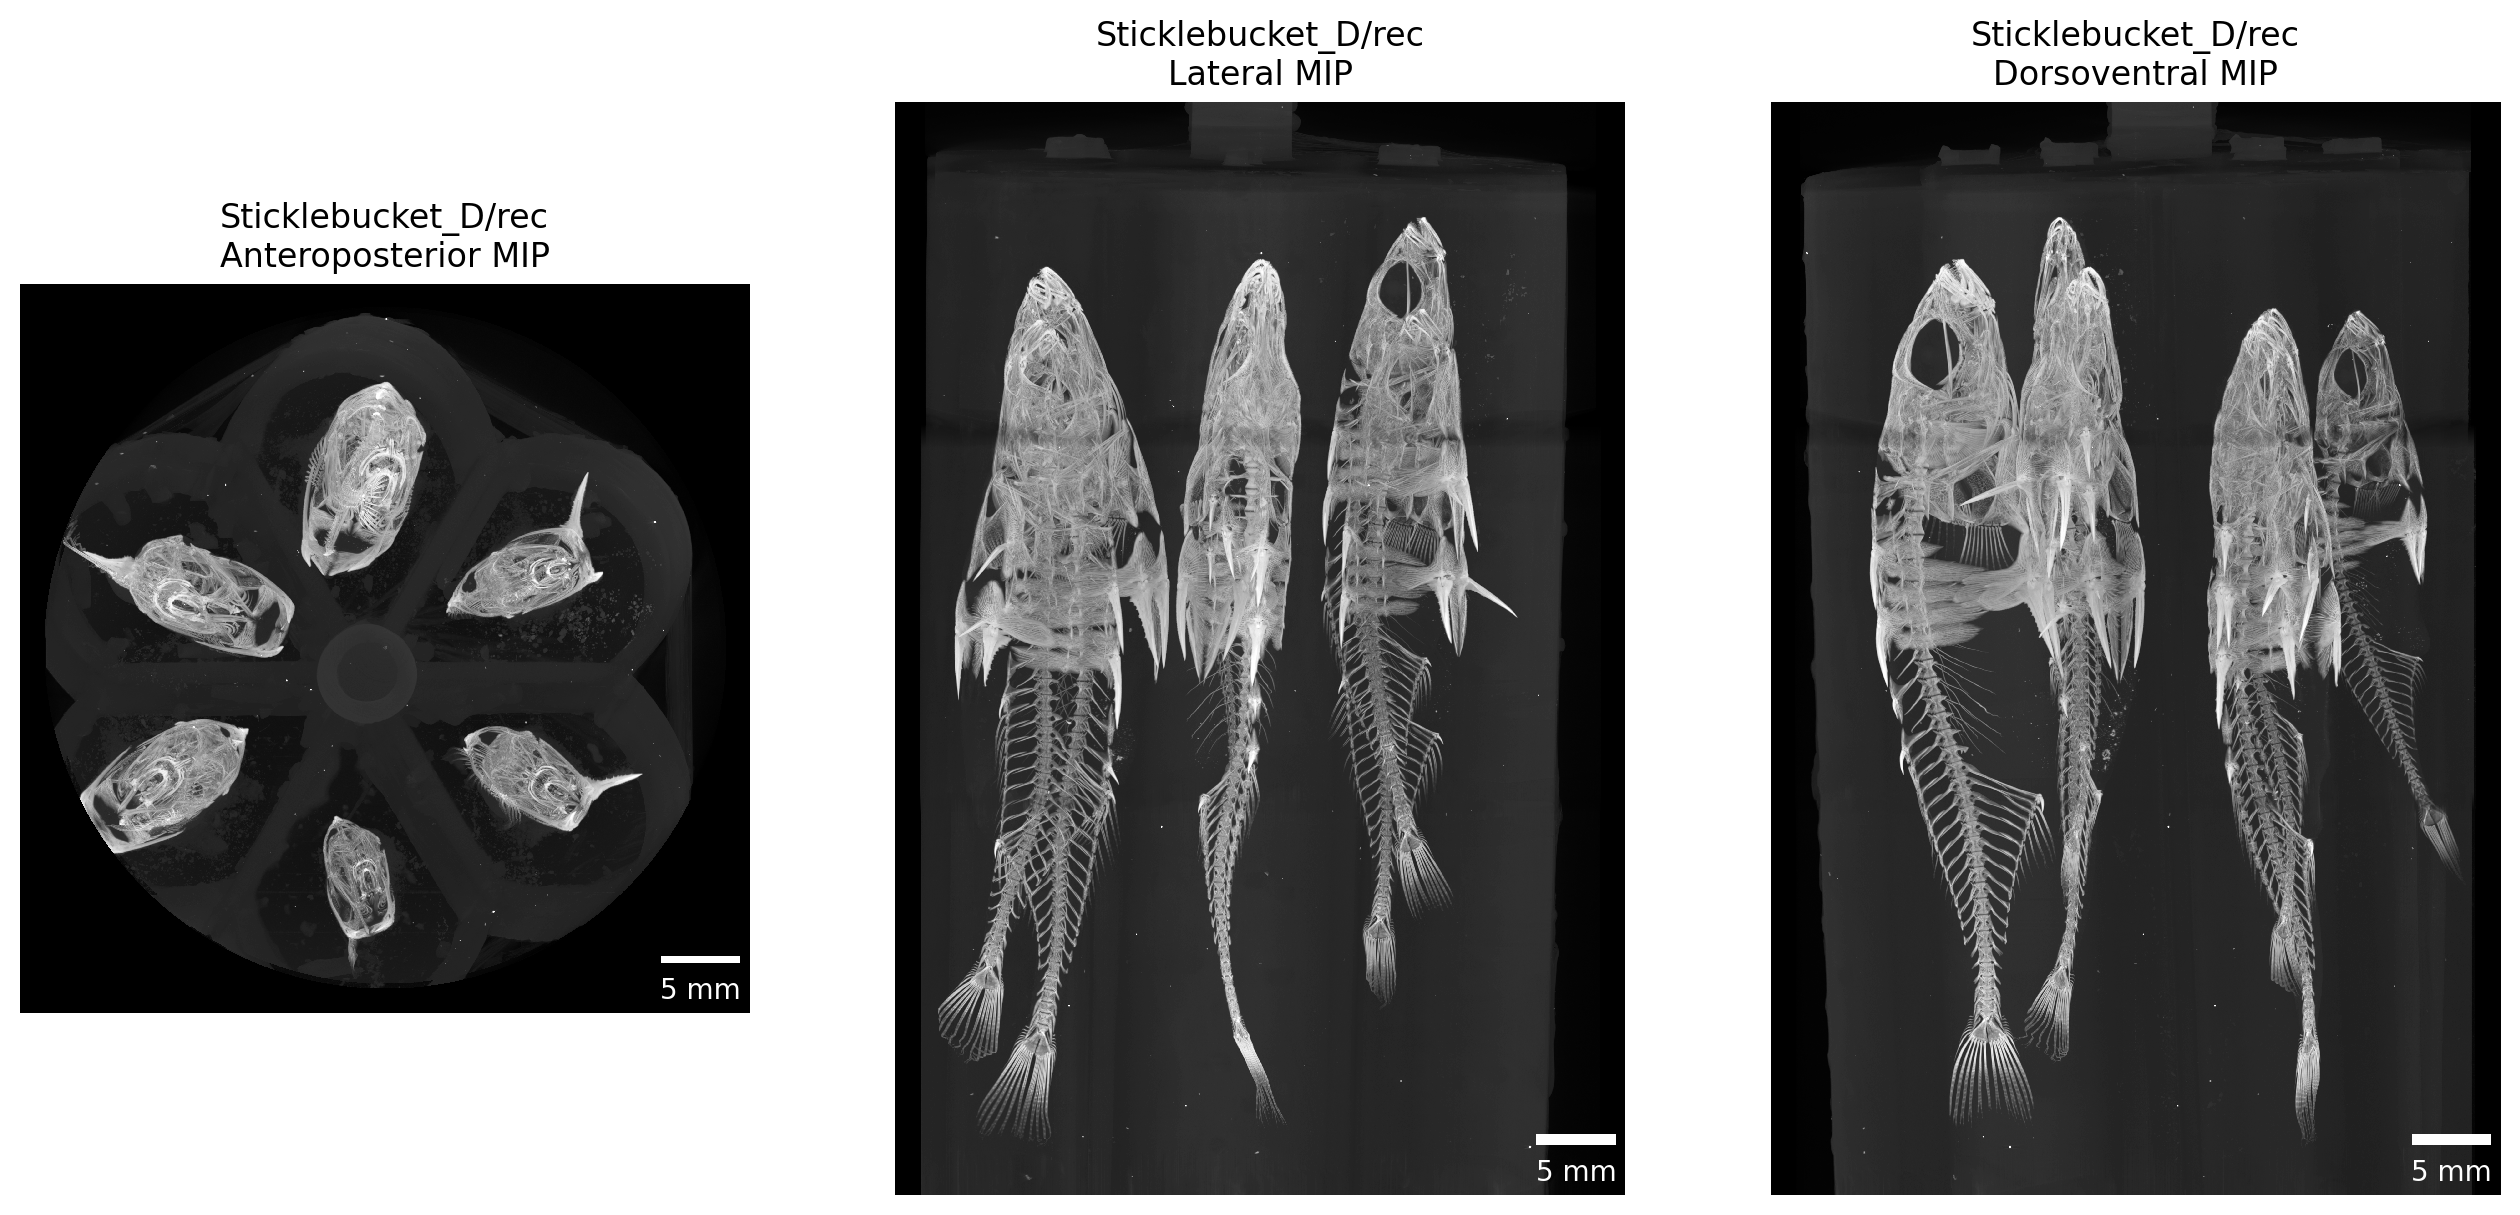

In [43]:
# Show/save MIP slices
for c, row in tqdm(Data.iterrows(),
                   desc='Saving overview of MIP images',
                   total=len(Data)):
    outfilepath = os.path.join(os.path.dirname(row['Folder']),
                               '%s.%s.MIPs.png' % (row['Sample'], row['Scan']))
    if not os.path.exists(outfilepath):
        for d, direction in tqdm(enumerate(directions),
                                 desc='%s/%s' % (row['Sample'], row['Scan']),
                                 leave=False,
                                 total=len(directions)):
            plt.subplot(1, 3, d + 1)
            plt.imshow(row['MIP_' + direction])
            plt.gca().add_artist(ScaleBar(row['Voxelsize'],
                                          'um'))
            plt.title('%s MIP' % direction)
            plt.axis('off')
            plt.title('%s\n%s MIP' % (os.path.join(row['Sample'], row['Scan']), direction))
            plt.savefig(outfilepath,
                        transparent=True,
                        bbox_inches='tight')
        plt.show()

For further checking the data, we look at the gray value histogram of the reconstructions.
This helps us to find scans that have not been reconstructed well and might either need to be repeated or simply re-reconstructed.

In [44]:
print('We have previewed %s scans of %s folders in %s' % (len(Data),
                                                          len(Data.Sample.unique()),
                                                          Root))

We have previewed 7 scans of 5 folders in /media/habi/Fast_SSD/IEE Stickleback
